<a href="https://colab.research.google.com/github/TamarRY/DronesBestDeliveryPath/blob/main/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**requirements:**

In [ ]:
import numpy as np
from more_itertools import unique_everseen
from operator import itemgetter
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


**problem constants:**




In [ ]:
COSTUMERS = 80
STORES = 40
GRID_SIZE = 320
POPULATION_COUNT = 80
POPULATION_INITAL_OPTIONS = 3
TRANSITION_TIME= 0.01 #changed it to fit the constrains 60~ was 0.002
MAX_AIR_TIME=60
FIRST_DELIVERY_TIME=1
SECOND_DELIVERY_TIME=4
THIRD_DELIVERY_TIME=7
PRICE_PER_DRONE = 2
PENALTY_PRICE = 10
BEST_GENES_NUMBER= 4 # number of best solutions to pass to the next generation
CROSSOVER_MUTATION_GENES_NUMBER= 20
ITERATIONS = 500
hyper_dist = 1.5
hyper_shops = 0.2

**generating stoers and costumers locations on grid:**




In [ ]:
stores_locations=np.array(np.random.choice(GRID_SIZE,(STORES,2), replace=False))
stores_locations=list(map(tuple, stores_locations))
stores_locations= np.array(stores_locations, dtype=np.dtype('int,int')) #shape = STORES, = 40,
print(stores_locations.shape)
costumers_locations= np.array(np.random.choice(GRID_SIZE,(COSTUMERS,2), replace=False))
costumers_locations=list(map(tuple, costumers_locations))
costumers_locations= np.array(costumers_locations, dtype=np.dtype('int,int')) #shape = COSTUMERS, = 100,


(40,)


**stores and costumers dictionery: key=name, val= location:**

In [ ]:
stores_pool = np.arange(2,STORES*2+2, 2) #shape= STORES, = 40,
costumers_pool= np.arange(1,COSTUMERS*2,2) #shape= COSTUMERS, = 100,
stores_dict=dict(zip(stores_pool, list(stores_locations)))
costumers_dict= dict(zip(costumers_pool, list(costumers_locations)))
locations_dict={}
locations_dict.update(stores_dict)
locations_dict.update(costumers_dict)
#print(stores_dict)
#print(costumers_dict)
#print(locations_dict)

**population initializing:**

In [ ]:
population = []
padded_costumers= np.pad(costumers_pool, (0, STORES*3-len(costumers_pool)), 'constant') #SHAPE= STORES*3,


**population initializing- option A:**

In [ ]:
for i in range(10 * POPULATION_COUNT//POPULATION_INITAL_OPTIONS):
  np.random.shuffle(padded_costumers)
  solution=np.zeros((STORES*4,), dtype=int) #len=160=stores*4
  solution[::4]= np.random.choice(stores_pool, STORES)
  solution[(np.where(solution==0)[0])]=padded_costumers
  population.append(solution)
# print(len(population[0]))

**population initializing- option B:**

In [ ]:
for i in range(10*POPULATION_COUNT//POPULATION_INITAL_OPTIONS):
  np.random.shuffle(padded_costumers)
  solution=np.zeros((STORES*4,), dtype=int) #len=160=stores*4
  solution[::4]= stores_pool
  solution[(np.where(solution==0)[0])]=padded_costumers
  population.append(solution)
#print(len(population))

**population initialize - c  40 solutions**




In [ ]:
i=0
while i < (40*POPULATION_COUNT//(POPULATION_INITAL_OPTIONS)):
  solution=np.zeros((STORES*4,), dtype=int) #len=160=stores*4
  solution[::4]= np.random.choice(stores_pool, STORES)
  stores_pool_1 = []
  costumers_pool_1= []
  stores_pool_2 =[]
  costumers_pool_2 = []
  stores_pool_3 = []
  costumers_pool_3 = []
  stores_pool_4 = []
  costumers_pool_4 = []
  costumers_pool_5 = []
  for costumer in costumers_pool:
    if costumers_dict[costumer][0] <= GRID_SIZE/2 and costumers_dict[costumer][1] <= GRID_SIZE/2:
      costumers_pool_1.append(costumer)
    if costumers_dict[costumer][0] <= GRID_SIZE/2 and costumers_dict[costumer][1] > GRID_SIZE/2:
      costumers_pool_2.append(costumer)
    if costumers_dict[costumer][0] > GRID_SIZE/2 and costumers_dict[costumer][1] <= GRID_SIZE/2:
      costumers_pool_3.append(costumer)
    if costumers_dict[costumer][0] > GRID_SIZE/2 and costumers_dict[costumer][1] > GRID_SIZE/2:
      costumers_pool_4.append(costumer)



  for stores in stores_pool:
    if stores_dict[stores][0] <= GRID_SIZE/2 and stores_dict[stores][1] <= GRID_SIZE/2:
      stores_pool_1.append(stores)
    if stores_dict[stores][0] <= GRID_SIZE/2 and stores_dict[stores][1] > GRID_SIZE/2:
      stores_pool_2.append(stores)
    if stores_dict[stores][0] > GRID_SIZE/2 and stores_dict[stores][1] <= GRID_SIZE/2:
      stores_pool_3.append(stores)
    if stores_dict[stores][0] > GRID_SIZE/2 and stores_dict[stores][1] > GRID_SIZE/2:
      stores_pool_4.append(stores)

    #check if costumers array is legal
  if len(costumers_pool_1) > 30:
    costumers_pool_5+=costumers_pool_1[30:]
    costumers_pool_1=costumers_pool_1[:30]
  if len(costumers_pool_2) > 30:
    costumers_pool_5+=costumers_pool_2[30:]
    costumers_pool_2=costumers_pool_2[:30]
  if len(costumers_pool_3) > 30:
    costumers_pool_5+=costumers_pool_3[30:]
    costumers_pool_3=costumers_pool_3[:30]
  if len(costumers_pool_4) > 30:
    costumers_pool_5+=costumers_pool_4[30:]
    costumers_pool_4=costumers_pool_4[:30]
  costumers_pool_5 = costumers_pool_5 + [0]*40

  random.shuffle(costumers_pool_5)


    #fit every coustumer quater to 30
  if len(costumers_pool_1) <= 30:
    costumers_pool_1 = costumers_pool_1 + costumers_pool_5[:(30-len(costumers_pool_1))]
    costumers_pool_5=costumers_pool_5[(30-len(costumers_pool_1)):]
    random.shuffle(costumers_pool_1)
  if len(costumers_pool_2) <= 30:
    costumers_pool_2 = costumers_pool_2 + costumers_pool_5[:(30-len(costumers_pool_2))]
    costumers_pool_5=costumers_pool_5[(30-len(costumers_pool_2)):]
    random.shuffle(costumers_pool_2)
  if len(costumers_pool_3) <= 30:
    costumers_pool_3 = costumers_pool_3 + costumers_pool_5[:(30-len(costumers_pool_3))]
    costumers_pool_5=costumers_pool_5[(30-len(costumers_pool_3)):]
    random.shuffle(costumers_pool_3)
  if len(costumers_pool_4) <= 30:
    costumers_pool_4 = costumers_pool_4 + costumers_pool_5[:(30-len(costumers_pool_4))]
    costumers_pool_5=costumers_pool_5[(30-len(costumers_pool_4)):]
    random.shuffle(costumers_pool_4)



  solution=np.zeros((STORES*4,), dtype=int) #len=160=stores*4
  stores_pool_total = stores_pool_1 + stores_pool_2 + stores_pool_3 + stores_pool_4
  costumers_pool_total = costumers_pool_1 + costumers_pool_2 + costumers_pool_3 + costumers_pool_4
  stores_pool_total = np.array(stores_pool_total)
  costumers_pool_total = np.array(costumers_pool_total)


  solution[::4] = stores_pool_total
  solution[(np.where(solution == 0)[0])] = costumers_pool_total
  i+=1

  population.append(solution)


**penalty function:**
gets a route per store: [store, costumer,costumer,costumer] and determinrs if constrained is violated

from here new code from oded

distance function

In [ ]:
# def calc_distance(a,b):
#    dist=0

#    if a % 2 == 0:
#      dist_a = stores_dict[a]
#    else:
#      dist_a = costumers_dict[a]
#    if b % 2 == 0:
#      dist_b = stores_dict[b]
#    else:
#      dist_b = costumers_dict[b]

#    for x,y in zip(dist_a,dist_b):
#      dist+=abs(x-y)

#    return dist

def calc_distance(a,b):
   dist=0

   if a % 2 == 0:
     dist_a = stores_dict[a]
   else:
     dist_a = costumers_dict[a]
   if b % 2 == 0:
     dist_b = stores_dict[b]
   else:
     dist_b = costumers_dict[b]

   for x,y in zip(dist_a,dist_b):
     dist+=(x-y)**2

   return dist**0.5

**fitness function**

In [ ]:
def fitness(route):
  distances = 0
  number_of_shops = np.zeros(3)
  for i in range(STORES):
    temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
    distance_temp_route=0
    for i in range(len(temp_route_no_0)-1):
      distance_temp_route += calc_distance(temp_route_no_0[i],temp_route_no_0[i+1])
      number_of_shops[i]+=1
    distances += distance_temp_route
  distances_price = distances*TRANSITION_TIME
  number_of_shops_price = FIRST_DELIVERY_TIME*number_of_shops[0] + SECOND_DELIVERY_TIME*number_of_shops[1] + THIRD_DELIVERY_TIME * number_of_shops[2]
  #number_of_drone_price = number_of_shops[0] * PRICE_PER_DRONE
  if (distances_price + number_of_shops_price) <= 60:
    penalty = 0
  else:
    penalty = ((distances_price + number_of_shops_price) - 60) * PENALTY_PRICE
  # print('distances_price',distances_price)
  # print('penalty', penalty)
  # print('number_of_drone_price',number_of_drone_price)
  # print('number_of_shops_price',number_of_shops_price)
  # print('number_of_shops',number_of_shops)
  # print('fittnes:', int(distances_price + number_of_shops_price + number_of_drone_price + penalty))
  #return int(distances_price + number_of_shops_price + penalty)
  return round(float(hyper_dist * distances_price- hyper_shops* number_of_shops_price),4)




In [ ]:
def fitness_for_single_route(route):
  distances = 0
  number_of_shops = np.zeros(3)
  for i in range(STORES):
    temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
    distance_temp_route=0
    for i in range(len(temp_route_no_0)-1):
      distance_temp_route += calc_distance(temp_route_no_0[i],temp_route_no_0[i+1])
      number_of_shops[i]+=1
    distances += distance_temp_route
  distances_price = distances*TRANSITION_TIME
  number_of_shops_price = -1 * number_of_shops[0] + -2 * number_of_shops[1] + -3 * number_of_shops[2]
  #number_of_drone_price = number_of_shops[0] * PRICE_PER_DRONE
  # print('distances_price',distances_price)
  # print('penalty', penalty)
  # print('number_of_drone_price',number_of_drone_price)
  # print('number_of_shops_price',number_of_shops_price)
  # print('number_of_shops',number_of_shops)
  # print('fittnes:', int(distances_price + number_of_shops_price + number_of_drone_price + penalty))

  return round(float(hyper_dist * distances_price - hyper_shops * number_of_shops_price), 4)




In [ ]:
def get_distance_price(route):
  distances = 0
  number_of_shops = np.zeros(3)
  for i in range(STORES):
    temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
    distance_temp_route=0
    for i in range(len(temp_route_no_0)-1):
      distance_temp_route += calc_distance(temp_route_no_0[i],temp_route_no_0[i+1])
      number_of_shops[i]+=1
    distances += distance_temp_route
  distances_price = distances*TRANSITION_TIME
  number_of_shops_price = FIRST_DELIVERY_TIME*number_of_shops[0] + SECOND_DELIVERY_TIME*number_of_shops[1] + THIRD_DELIVERY_TIME * number_of_shops[2]
  #number_of_drone_price = number_of_shops[0] * PRICE_PER_DRONE
  if (distances_price + number_of_shops_price) <= 60:
    penalty = 0
  else:
    penalty = ((distances_price + number_of_shops_price) - 60) * PENALTY_PRICE
  return round(float(hyper_dist * distances_price),4)

In [ ]:
def get_shops_price(route):
  distances = 0
  number_of_shops = np.zeros(3)
  for i in range(STORES):
    temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
    distance_temp_route=0
    for i in range(len(temp_route_no_0)-1):
      distance_temp_route += calc_distance(temp_route_no_0[i],temp_route_no_0[i+1])
      number_of_shops[i]+=1
    distances += distance_temp_route
  distances_price = distances*TRANSITION_TIME
  number_of_shops_price = FIRST_DELIVERY_TIME*number_of_shops[0] + SECOND_DELIVERY_TIME*number_of_shops[1] + THIRD_DELIVERY_TIME * number_of_shops[2]
  #number_of_drone_price = number_of_shops[0] * PRICE_PER_DRONE
  if (distances_price + number_of_shops_price) <= 60:
    penalty = 0
  else:
    penalty = ((distances_price + number_of_shops_price) - 60) * PENALTY_PRICE
  # print('distances_price',distances_price)
  # print('penalty', penalty)
  # print('number_of_drone_price',number_of_drone_price)
  # print('number_of_shops_price',number_of_shops_price)
  # print('number_of_shops',number_of_shops)
  # print('fittnes:', int(distances_price + number_of_shops_price + number_of_drone_price + penalty))
  #return int(distances_price + number_of_shops_price + penalty)
  return round(float(hyper_shops * number_of_shops_price),4)



first crossover and mutation:

In [ ]:
def crossover_and_mutation_1(father, mother):
  child=np.zeros((len(father),), dtype=int) #len=160
  child[:len(father)//2]= father[:len(father)//2]
  mother_stores= mother[len(mother)//2::4]
  child[len(mother)//2::4]= mother_stores
  for i in range(len(mother)//2 , len(mother)):
    if i%4 != 0:
      if not (mother[i] in child) and mother[i] != 0:
        child[i] = mother[i]
  missing_costumers= [costumer for costumer in costumers_pool if costumer not in child]
  missing_costumers+= [0]* (len(child[(np.where(child==0)[0])])-len(missing_costumers))
  np.random.shuffle(missing_costumers)
  child[(np.where(child==0)[0])]=missing_costumers
  return child


2nd crosoover and mutation:

In [ ]:
def crossover_and_mutation_2_0(father,mother):
    child=np.zeros((len(father),), dtype=int) #len=160
    child[:len(father)//2]= father[:len(father)//2]
    mother_stores= mother[len(mother)//2::4]
    child[len(mother)//2::4]= mother_stores
    for i in range(len(mother)//2 , len(mother)):
      if i%4 != 0:
        if not (mother[i] in child) and mother[i] != 0:
          child[i] = mother[i]
    missing_costumers= [costumer for costumer in costumers_pool if costumer not in child]
    missing_costumers+= [0]* (len(child[(np.where(child==0)[0])])-len(missing_costumers))
    np.random.shuffle(missing_costumers)
    child[(np.where(child==0)[0])]=missing_costumers
    shuffle_array = np.arange(0,157,4)
    np.random.shuffle(shuffle_array)
    for i in range(5): #mutation
      route_temp_1 = child[shuffle_array[i]:shuffle_array[i]+4].tolist()
      route_temp_2 = child[shuffle_array[i+4]: shuffle_array[i+4]+4].tolist()
      child[shuffle_array[i]:shuffle_array[i]+4] = route_temp_2
      child[shuffle_array[i+4]: shuffle_array[i+4]+4] = route_temp_1
    return child

In [ ]:
  def crossover_and_mutation_2(father,mother):
    child=np.zeros((len(father),), dtype=int) #len=160
    child[:len(father)//2]= father[:len(father)//2]
    mother_stores= mother[len(mother)//2::4]
    child[len(mother)//2::4]= mother_stores
    for i in range(len(mother)//2 , len(mother)):
      if i%4 != 0:
        if not (mother[i] in child) and mother[i] != 0:
          child[i] = mother[i]
    missing_costumers= [costumer for costumer in costumers_pool if costumer not in child]
    missing_costumers+= [0]* (len(child[(np.where(child==0)[0])])-len(missing_costumers))
    np.random.shuffle(missing_costumers)
    child[(np.where(child==0)[0])]=missing_costumers
    shuffle_array = np.arange(0,157,4)
    np.random.shuffle(shuffle_array)
    #new
    np.random.shuffle(stores_pool)
    for j in range(4):  # mutation of shops 12.5%
        child[shuffle_array[j]] = stores_pool[j]
    #new
    np.random.shuffle(costumers_pool)
    shuffle_array_costumer = np.arange(0,160)
    np.random.shuffle(shuffle_array_costumer)
    for m in range(6):  # mutation of shops 12.5%
        if  child[shuffle_array[m]] % 4 !=0:
            child[shuffle_array[m]] = costumers_pool[m]
    #new
    for i in range(5): #mutation
      route_temp_1 = child[shuffle_array[i]:shuffle_array[i]+4].tolist()
      route_temp_2 = child[shuffle_array[i+4]: shuffle_array[i+4]+4].tolist()
      child[shuffle_array[i]:shuffle_array[i]+4] = route_temp_2
      child[shuffle_array[i+4]: shuffle_array[i+4]+4] = route_temp_1
    return child

3RD CROSSOVER AND MUTATION

In [ ]:
def take_second(elem):
    return elem[1]

def crossover_and_mutation_3(father,mother):
    #child=np.zeros((len(father),), dtype=int) #len=160
    parents = father.tolist() + mother.tolist()
    parents=np.array(parents)
    parents_sorted = []
    for i in range(STORES*2):
      single_route = parents[i*4:i*4+4][parents[i*4:i*4+4]!=0]
      fitness_route = fitness_for_single_route(single_route)
      parents_sorted.append((single_route.tolist(),fitness_route))
    parents_sorted.sort(key = take_second)
    child=[]
    #for route in parents_sorted:
    i=0
    while len(child) < 160:
        route = parents_sorted[i][0] + [0]*(4-len(parents_sorted[i][0]))
        child += route
        i+=1
    for i in range(len(child)):
      if child[i]!=0 and child[i] % 2 !=0 and child.count(child[i])>1:
        child[i]=0
    child = np.array(child)
    missing_costumers= [costumer for costumer in costumers_pool if costumer not in child]
    missing_costumers+= [0]* (len(child[(np.where(child==0)[0])])-len(missing_costumers))
    np.random.shuffle(missing_costumers)
    child[(np.where(child==0)[0])]=missing_costumers
    return child

4th crossover and mutation - random shop change

In [ ]:
def take_second(elem):
    return elem[1]

def crossover_and_mutation_4(father,mother):
    #child=np.zeros((len(father),), dtype=int) #len=160
    parents = father.tolist() + mother.tolist()
    parents=np.array(parents)
    parents_sorted = []
    for i in range(STORES*2):
      single_route = parents[i*4:i*4+4][parents[i*4:i*4+4]!=0]
      fitness_route = fitness_for_single_route(single_route)
      parents_sorted.append((single_route.tolist(),fitness_route))
    parents_sorted.sort(key = take_second)
    child=[]
    #for route in parents_sorted:
    i=0
    while len(child) < 160:
        route = parents_sorted[i][0] + [0]*(4-len(parents_sorted[i][0]))
        child += route
        i+=1
    for i in range(len(child)):
      if child[i]!=0 and child[i] % 2 !=0 and child.count(child[i])>1:
        child[i]=0
    child = np.array(child)
    missing_costumers= [costumer for costumer in costumers_pool if costumer not in child]
    missing_costumers+= [0]* (len(child[(np.where(child==0)[0])])-len(missing_costumers))
    np.random.shuffle(missing_costumers)
    child[(np.where(child==0)[0])]=missing_costumers
    shuffle_array = np.arange(0,157,4)
    np.random.shuffle(shuffle_array)
    np.random.shuffle(stores_pool)
    for i in range(8): #mutation of shops 12.5%
      child[shuffle_array[i]] = stores_pool[i]
    return child

In [ ]:
def plot_routes(route, fit_score, iteration):
  fig, ax = plt.subplots(1, 2, figsize=(10,4))


  for i in range(STORES):
      temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
      x_axis = []
      y_axis = []
      for j in range(len(temp_route_no_0)):
        if temp_route_no_0[j] %2 == 0:
          x_axis.append(stores_dict[temp_route_no_0[j]][0])
          y_axis.append((stores_dict[temp_route_no_0[j]][1]))
        else:
          x_axis.append(costumers_dict[temp_route_no_0[j]][0])
          y_axis.append((costumers_dict[temp_route_no_0[j]][1]))
        ax[0].plot(x_axis, y_axis, '--o')
        ax[1].plot(x_axis, y_axis, '--o')

  ax[0].title.set_text("fitness score = {} \n iteration number {}  ".format(fit_score, iteration))
  ax[1].title.set_text("ZOOM IN \n fitness score = {} \n iteration number {}".format(fit_score, iteration))


  ax[1].margins(x=-0.1, y=-0.1)
  plt.savefig("fitnes {}, RAMSLHAT 400 scale only good population and fixed grid iteration {}.svg".format(fit_score, iteration))
  return plt.show()

ganerting new generations:

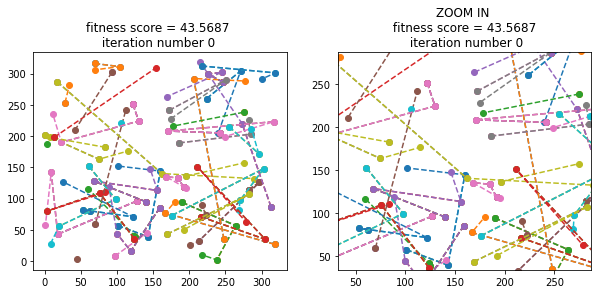

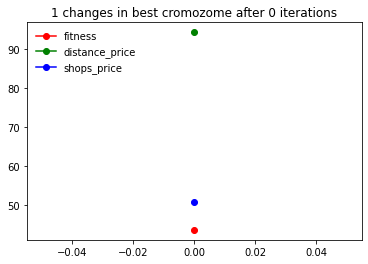

ITERATION 0 SCORE 43.5687


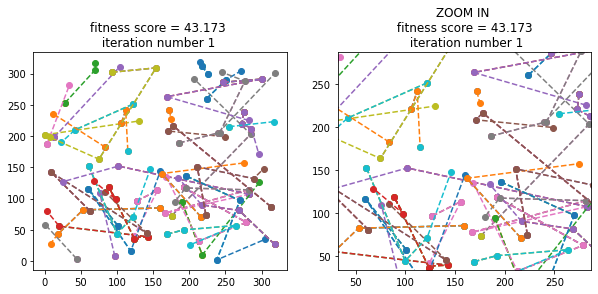

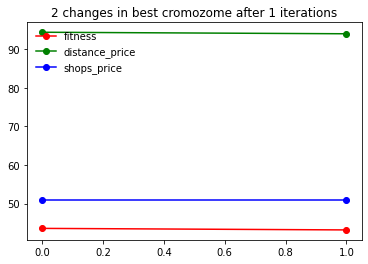

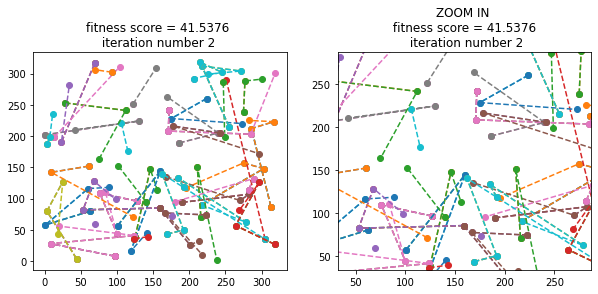

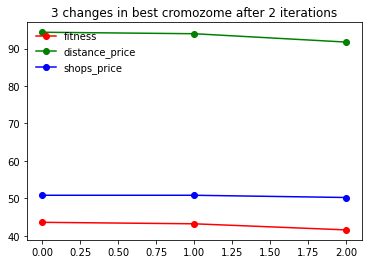

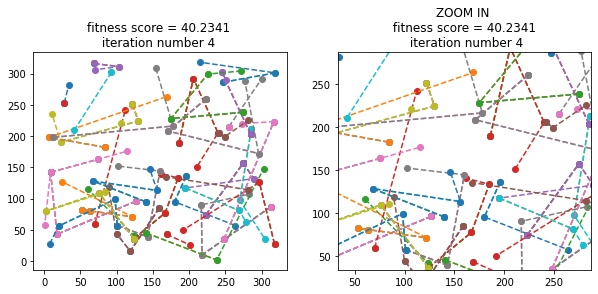

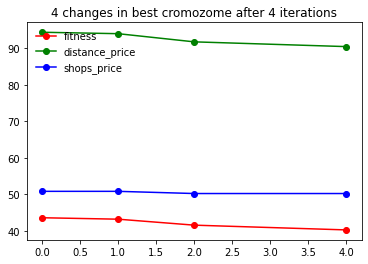

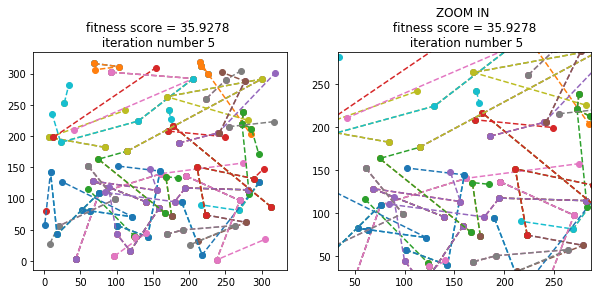

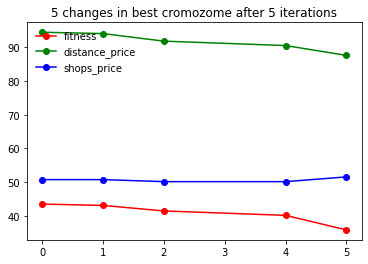

ITERATION 5 SCORE 35.9278
ITERATION 10 SCORE 35.9278
ITERATION 15 SCORE 35.9278
ITERATION 20 SCORE 35.9278
ITERATION 25 SCORE 35.9278
ITERATION 30 SCORE 35.9278
ITERATION 35 SCORE 35.9278
ITERATION 40 SCORE 35.9278


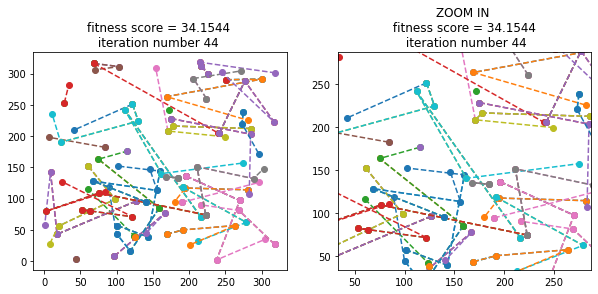

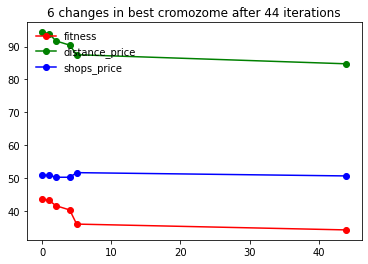

ITERATION 45 SCORE 34.1544
ITERATION 50 SCORE 34.1544
ITERATION 55 SCORE 34.1544
ITERATION 60 SCORE 34.1544
ITERATION 65 SCORE 34.1544
ITERATION 70 SCORE 34.1544
ITERATION 75 SCORE 34.1544
ITERATION 80 SCORE 34.1544
ITERATION 85 SCORE 34.1544


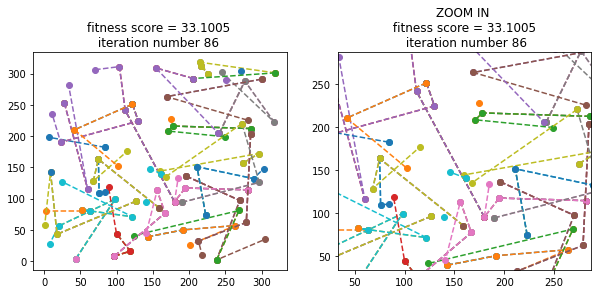

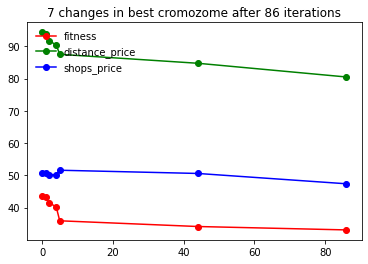

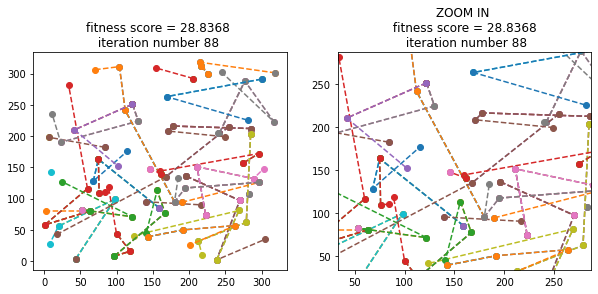

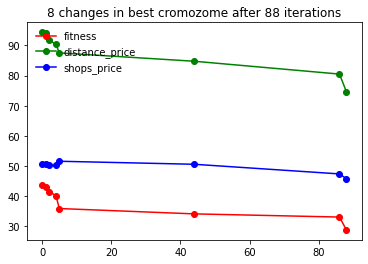

ITERATION 90 SCORE 28.8368
ITERATION 95 SCORE 28.8368
ITERATION 100 SCORE 28.8368
ITERATION 105 SCORE 28.8368
ITERATION 110 SCORE 28.8368
ITERATION 115 SCORE 28.8368
ITERATION 120 SCORE 28.8368
ITERATION 125 SCORE 28.8368


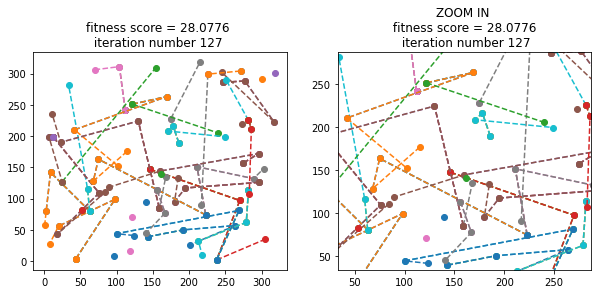

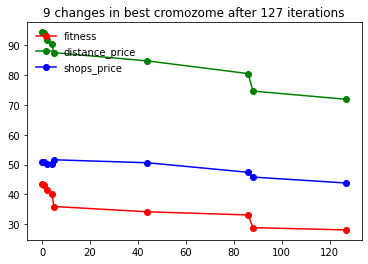

ITERATION 130 SCORE 28.0776
ITERATION 135 SCORE 28.0776


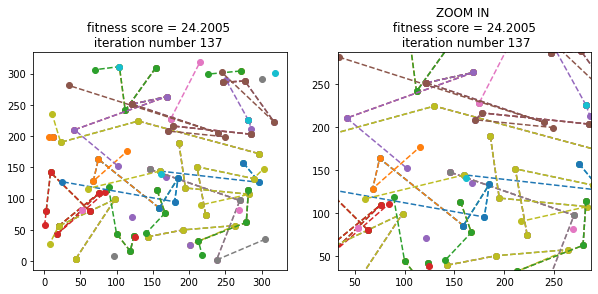

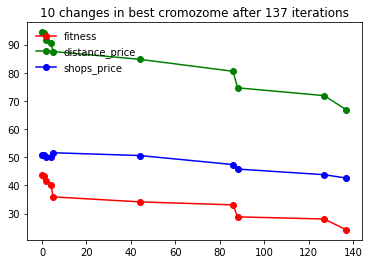

ITERATION 140 SCORE 24.2005
ITERATION 145 SCORE 24.2005
ITERATION 150 SCORE 24.2005
ITERATION 155 SCORE 24.2005
ITERATION 160 SCORE 24.2005
ITERATION 165 SCORE 24.2005
ITERATION 170 SCORE 24.2005
ITERATION 175 SCORE 24.2005
ITERATION 180 SCORE 24.2005
ITERATION 185 SCORE 24.2005
ITERATION 190 SCORE 24.2005
ITERATION 195 SCORE 24.2005
ITERATION 200 SCORE 24.2005
ITERATION 205 SCORE 24.2005
ITERATION 210 SCORE 24.2005
ITERATION 215 SCORE 24.2005
ITERATION 220 SCORE 24.2005
ITERATION 225 SCORE 24.2005
ITERATION 230 SCORE 24.2005
ITERATION 235 SCORE 24.2005
ITERATION 240 SCORE 24.2005
ITERATION 245 SCORE 24.2005
ITERATION 250 SCORE 24.2005
ITERATION 255 SCORE 24.2005
ITERATION 260 SCORE 24.2005
ITERATION 265 SCORE 24.2005
ITERATION 270 SCORE 24.2005


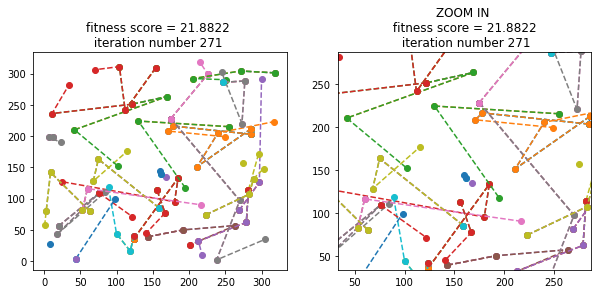

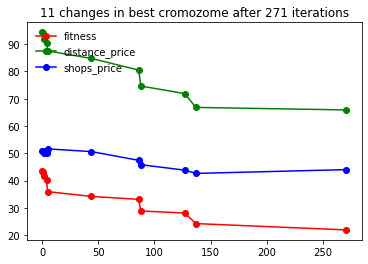

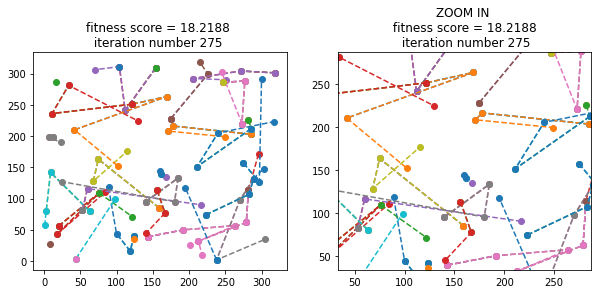

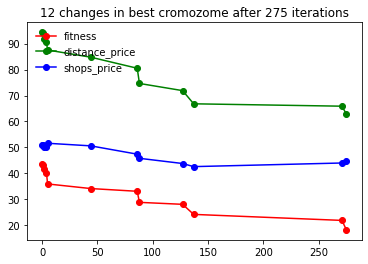

ITERATION 275 SCORE 18.2188
ITERATION 280 SCORE 18.2188
ITERATION 285 SCORE 18.2188
ITERATION 290 SCORE 18.2188
ITERATION 295 SCORE 18.2188
ITERATION 300 SCORE 18.2188
ITERATION 305 SCORE 18.2188
ITERATION 310 SCORE 18.2188
ITERATION 315 SCORE 18.2188
ITERATION 320 SCORE 18.2188
ITERATION 325 SCORE 18.2188
ITERATION 330 SCORE 18.2188
ITERATION 335 SCORE 18.2188
ITERATION 340 SCORE 18.2188
ITERATION 345 SCORE 18.2188
ITERATION 350 SCORE 18.2188
ITERATION 355 SCORE 18.2188
ITERATION 360 SCORE 18.2188
ITERATION 365 SCORE 18.2188
ITERATION 370 SCORE 18.2188
ITERATION 375 SCORE 18.2188
ITERATION 380 SCORE 18.2188
ITERATION 385 SCORE 18.2188
ITERATION 390 SCORE 18.2188


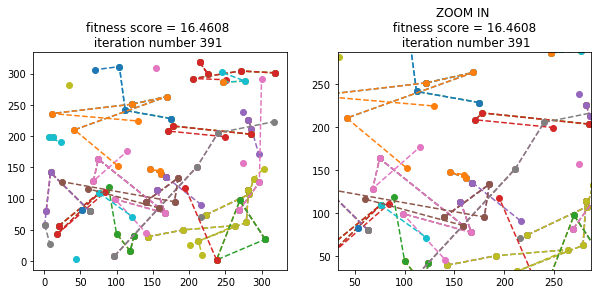

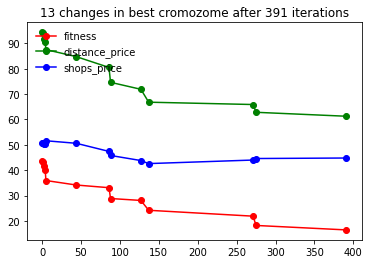

ITERATION 395 SCORE 16.4608
ITERATION 400 SCORE 16.4608
ITERATION 405 SCORE 16.4608
ITERATION 410 SCORE 16.4608
ITERATION 415 SCORE 16.4608
ITERATION 420 SCORE 16.4608
ITERATION 425 SCORE 16.4608
ITERATION 430 SCORE 16.4608
ITERATION 435 SCORE 16.4608
ITERATION 440 SCORE 16.4608
ITERATION 445 SCORE 16.4608
ITERATION 450 SCORE 16.4608


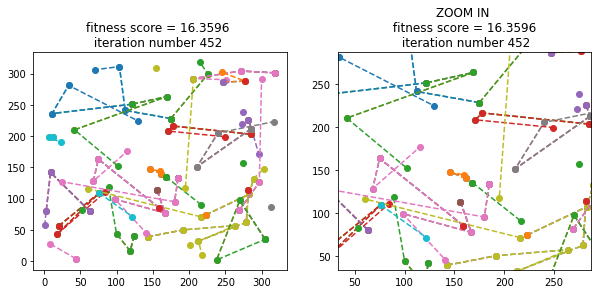

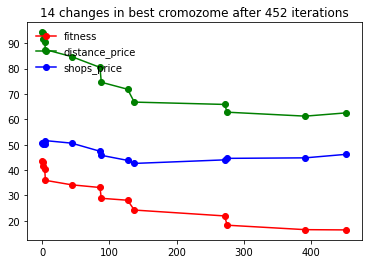

ITERATION 455 SCORE 16.3596
ITERATION 460 SCORE 16.3596
ITERATION 465 SCORE 16.3596


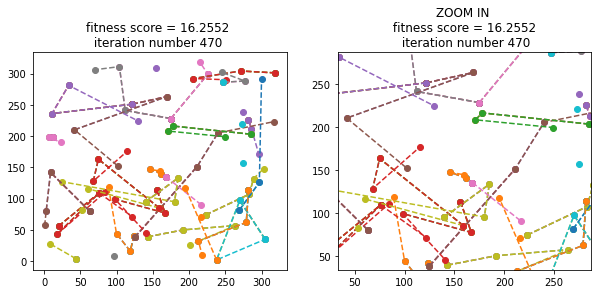

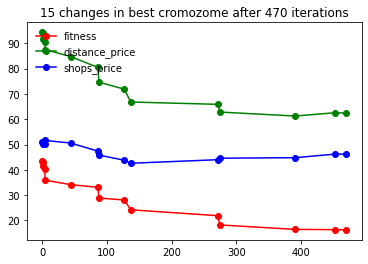

ITERATION 470 SCORE 16.2552
ITERATION 475 SCORE 16.2552
ITERATION 480 SCORE 16.2552
ITERATION 485 SCORE 16.2552
ITERATION 490 SCORE 16.2552
ITERATION 495 SCORE 16.2552


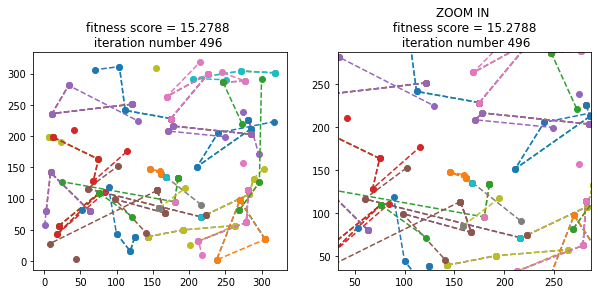

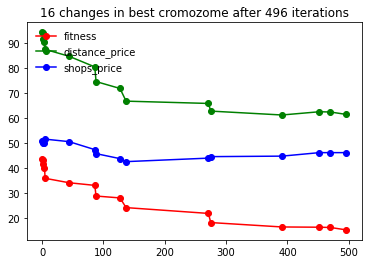

ITERATION 500 SCORE 15.2788
ITERATION 505 SCORE 15.2788
ITERATION 510 SCORE 15.2788
ITERATION 515 SCORE 15.2788
ITERATION 520 SCORE 15.2788
ITERATION 525 SCORE 15.2788
ITERATION 530 SCORE 15.2788
ITERATION 535 SCORE 15.2788
ITERATION 540 SCORE 15.2788
ITERATION 545 SCORE 15.2788
ITERATION 550 SCORE 15.2788
ITERATION 555 SCORE 15.2788
ITERATION 560 SCORE 15.2788
ITERATION 565 SCORE 15.2788
ITERATION 570 SCORE 15.2788


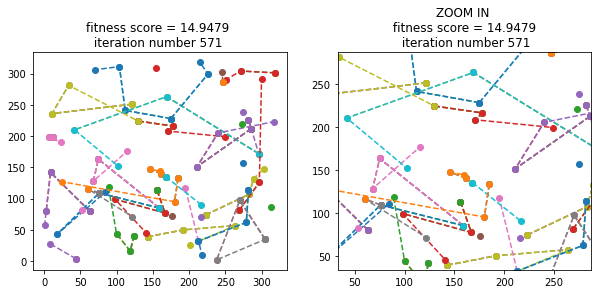

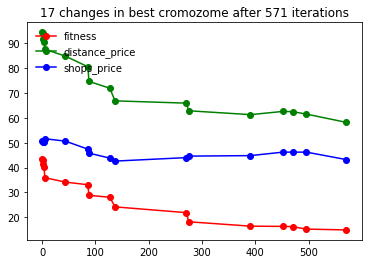

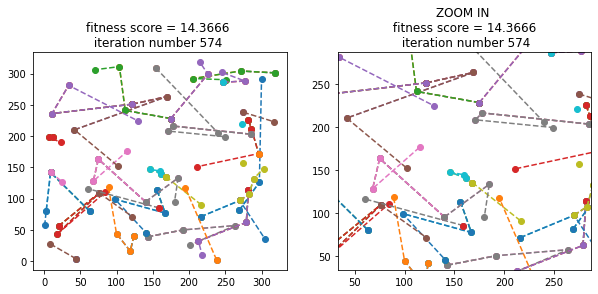

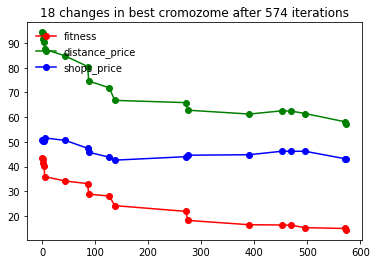

ITERATION 575 SCORE 14.3666
ITERATION 580 SCORE 14.3666
ITERATION 585 SCORE 14.3666
ITERATION 590 SCORE 14.3666
ITERATION 595 SCORE 14.3666
ITERATION 600 SCORE 14.3666
ITERATION 605 SCORE 14.3666
ITERATION 610 SCORE 14.3666
ITERATION 615 SCORE 14.3666
ITERATION 620 SCORE 14.3666
ITERATION 625 SCORE 14.3666
ITERATION 630 SCORE 14.3666


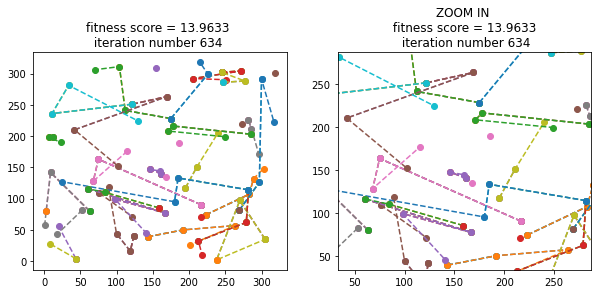

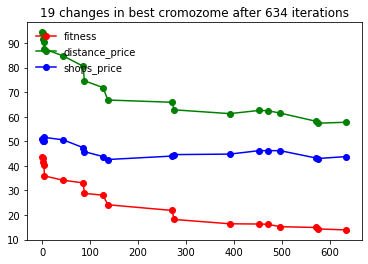

ITERATION 635 SCORE 13.9633
ITERATION 640 SCORE 13.9633
ITERATION 645 SCORE 13.9633
ITERATION 650 SCORE 13.9633
ITERATION 655 SCORE 13.9633
ITERATION 660 SCORE 13.9633
ITERATION 665 SCORE 13.9633
ITERATION 670 SCORE 13.9633
ITERATION 675 SCORE 13.9633
ITERATION 680 SCORE 13.9633
ITERATION 685 SCORE 13.9633
ITERATION 690 SCORE 13.9633
ITERATION 695 SCORE 13.9633
ITERATION 700 SCORE 13.9633
ITERATION 705 SCORE 13.9633
ITERATION 710 SCORE 13.9633


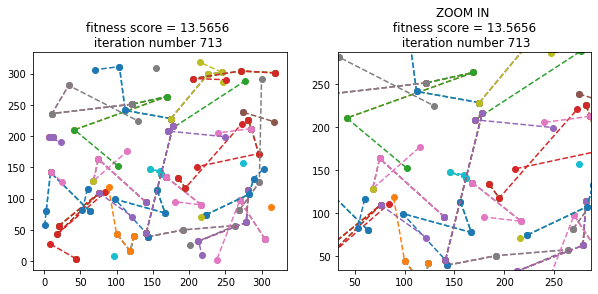

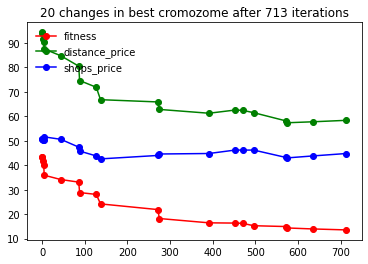

ITERATION 715 SCORE 13.5656
ITERATION 720 SCORE 13.5656
ITERATION 725 SCORE 13.5656


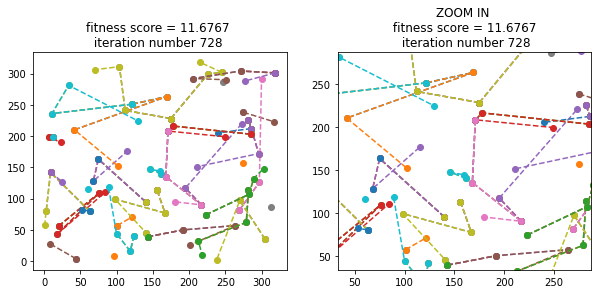

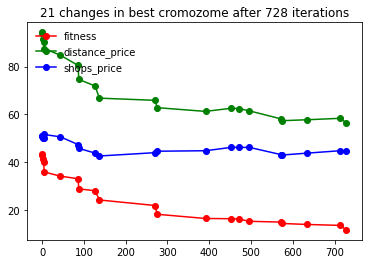

ITERATION 730 SCORE 11.6767
ITERATION 735 SCORE 11.6767
ITERATION 740 SCORE 11.6767
ITERATION 745 SCORE 11.6767
ITERATION 750 SCORE 11.6767
ITERATION 755 SCORE 11.6767
ITERATION 760 SCORE 11.6767
ITERATION 765 SCORE 11.6767
ITERATION 770 SCORE 11.6767
ITERATION 775 SCORE 11.6767
ITERATION 780 SCORE 11.6767
ITERATION 785 SCORE 11.6767
ITERATION 790 SCORE 11.6767
ITERATION 795 SCORE 11.6767
ITERATION 800 SCORE 11.6767
ITERATION 805 SCORE 11.6767
ITERATION 810 SCORE 11.6767
ITERATION 815 SCORE 11.6767
ITERATION 820 SCORE 11.6767
ITERATION 825 SCORE 11.6767
ITERATION 830 SCORE 11.6767
ITERATION 835 SCORE 11.6767
ITERATION 840 SCORE 11.6767
ITERATION 845 SCORE 11.6767
ITERATION 850 SCORE 11.6767
ITERATION 855 SCORE 11.6767
ITERATION 860 SCORE 11.6767
ITERATION 865 SCORE 11.6767
ITERATION 870 SCORE 11.6767
ITERATION 875 SCORE 11.6767
ITERATION 880 SCORE 11.6767
ITERATION 885 SCORE 11.6767
ITERATION 890 SCORE 11.6767
ITERATION 895 SCORE 11.6767
ITERATION 900 SCORE 11.6767
ITERATION 905 SCORE 

In [ ]:
fitness_plot=[]
distance_price_plot=[]
shops_price_plot=[]
fitness_avg_plot=[]
best_score = [1000]
l=0
iteration_change=[]

current_population=population
for i in range(1002):
  fitted_solutions=[(solution,fitness(solution)) for solution in current_population ]
  fitted_solutions.sort(key=lambda tup: tup[1])
  #appending the best route values to plot
  #fitness_plot.append(fitted_solutions[0][1])
  #distance_price_plot.append(get_distance_price(fitted_solutions[0][0]))
  #shops_price_plot.append(get_shops_price(fitted_solutions[0][0]))

  #print([fitted_solution[1] for fitted_solution in fitted_solutions])
  fitness_avg_plot.append(sum([fitted_solution[1] for fitted_solution in fitted_solutions[:20]]) / len(fitted_solutions[:20])) #avg on the best 20
  best_score.append(fitted_solutions[0][1])

  #print(sum([fitted_solution[1] for fitted_solution in fitted_solutions]) / len(fitted_solutions))
  next_generation= [ fitted_solution[0] for fitted_solution in fitted_solutions[:BEST_GENES_NUMBER + 10]]
  parents_for_cross_and_mutation= [ fitted_solution[0] for fitted_solution in fitted_solutions[:20]]
  parents_for_cross_and_mutation+= random.sample(current_population, 4)
  for j in range(200):
    # parents= random.sample(parents_for_cross_and_mutation, 2)
    np.random.shuffle(parents_for_cross_and_mutation)
    father, mother, mother_2, father_2= parents_for_cross_and_mutation[0], parents_for_cross_and_mutation[1], parents_for_cross_and_mutation[2], parents_for_cross_and_mutation[3]
    next_generation.append(crossover_and_mutation_4(father,mother_2))
    next_generation.append(crossover_and_mutation_2(mother,father_2))
    next_generation.append(crossover_and_mutation_2(mother,father_2))
    next_generation.append(crossover_and_mutation_4(father,mother_2))
  current_population=next_generation
  if best_score[i+1] !=best_score[i]:
    plot_routes(next_generation[0], best_score[i+1], i)
    l+=1
    iteration_change.append(i)
    fitness_plot.append(fitted_solutions[0][1])
    distance_price_plot.append(get_distance_price(fitted_solutions[0][0]))
    shops_price_plot.append(get_shops_price(fitted_solutions[0][0]))
    plt.plot(iteration_change, fitness_plot,'-ok',color='r', label='fitness')
    plt.plot(iteration_change, distance_price_plot,'-ok',color='g', label='distance_price')
    plt.plot(iteration_change, shops_price_plot,'-ok',color='b', label='shops_price')
    plt.legend(loc='upper left', frameon=False)
    plt.title('{} changes in best cromozome after {} iterations'.format(l,i))
    plt.savefig("graph itrantion {}".format(i))

    plt.show()
  if i % 5 == 0:
      print('ITERATION', i, 'SCORE', best_score[i+1])
  #if i % 50 == 0:
      #print(i)
      #print('ITERATION', i, 'len', len(fitness_plot))
      #plt.plot(range(i+1), fitness_plot,color='r', label='fitness')
      #plt.plot(range(i+1), distance_price_plot,color='g', label='distance_price')
      #plt.plot(range(i+1), shops_price_plot,color='b', label='shops_price')
      #plt.legend(loc='center right')
      #plt.savefig("graph itrantion {}".format(i))
      #plt.show()

odeds plot - route plots

In [ ]:
def plot_routes_draft(route, fit_score, iteration):
  for i in range(STORES):
      temp_route_no_0 = route[i*4:i*4+4][route[i*4:i*4+4]!=0]
      x_axis = []
      y_axis = []
      for j in range(len(temp_route_no_0)):
        if temp_route_no_0[j] %2 == 0:
          x_axis.append(stores_dict[temp_route_no_0[j]][0])
          y_axis.append((stores_dict[temp_route_no_0[j]][1]))
        else:
          x_axis.append(costumers_dict[temp_route_no_0[j]][0])
          y_axis.append((costumers_dict[temp_route_no_0[j]][1]))
        plt.subplot(1, 2, 1)
        plt.plot(x_axis, y_axis, '--o')
        plt.subplot(1, 2, 2)
        plt.plot(x_axis, y_axis, '--o')
  #plt.margins(x=-0.25, y=-0.25)
  plt.subplot(1, 2, 1)
  plt.title("fitness score = {} \n iteration number {}  ".format(fit_score, iteration))
  plt.subplot(1, 2, 2)
  plt.title("ZOOM IN \n fitness score = {} \n iteration number {}".format(fit_score, iteration))
  plt.margins(x=-0.25, y=-0.25)
  #plt.savefig("fitnes {}.svg".format(fit_score))
  return plt.show()